<a href="https://colab.research.google.com/github/lorebianchi98/BrainTumorClassification/blob/main/0_Data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing
In this notebook we are going to download the dataset from kaggle and to split it in train, validation and test set.

# Import and Costants

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import imutils
from tqdm import tqdm
from google.colab import drive

# Connection to Google Drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%run /content/gdrive/MyDrive/BrainTumorClassifier/utilities.ipynb

# Download of the dataset

We install kaggle, upload the json token provided by the platform and perform the local download of the dataset.

In [ ]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
%%capture
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset 
! unzip brain-tumor-mri-dataset.zip -d brain-tumor-mri-dataset
! rm brain-tumor-mri-dataset.zip

The dataset is provided in two directories: Training and Testing. About 18.67% of the images are in the Testing folder. Since we want to change this percentage for the train-test split, we move all the images in another folder before creating the data splits.

In [ ]:
for label in CLASSES:
  #path
  training_path = DATA_DIR + '/Training/' + label
  test_path = DATA_DIR + '/Testing/' + label
  new_path = DATA_DIR + '/' + label

  os.mkdir(new_path)
  #files
  training_files = os.listdir(training_path)
  test_files = os.listdir(test_path)
  
  print(label)
  print("Images in train directory: " + str(len(training_files)))
  print("Images in test directory: "+ str(len(test_files)))

  #moving files in the new directory
  for f in training_files:
    os.rename(training_path + '/' + f, new_path + '/' + f)
  for f in test_files:
    os.rename(test_path + '/' + f, new_path + '/' + f)

  os.rmdir(training_path)
  os.rmdir(test_path)

  print("Images in the new directory: "+ str(len(os.listdir(new_path))))
  
os.rmdir(DATA_DIR + '/Training')
os.rmdir(DATA_DIR + '/Testing')

glioma
Images in train directory: 1321
Images in test directory: 300
Images in the new directory: 1621
meningioma
Images in train directory: 1339
Images in test directory: 306
Images in the new directory: 1645
notumor
Images in train directory: 1595
Images in test directory: 405
Images in the new directory: 2000
pituitary
Images in train directory: 1457
Images in test directory: 300
Images in the new directory: 1757


We show the distribution of classes in the dataset.

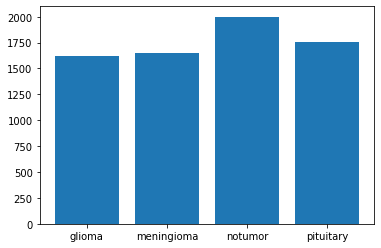

In [ ]:
num_per_classes = {}
for label in CLASSES:
  path = DATA_DIR + '/' + label
  num_per_classes[label] = len(os.listdir(path))

keys = list(num_per_classes.keys())  
values = list(num_per_classes.values())

plt.bar(range(len(CLASSES)), values, tick_label=keys)
plt.show()


As we can see the dataset is almost balanced.

Some examples of the images of the dataset are shown below. As we can see the images of the MRI scans on the dataset have different sizes

Text(0.5, 1.0, '(512, 512, 3)')

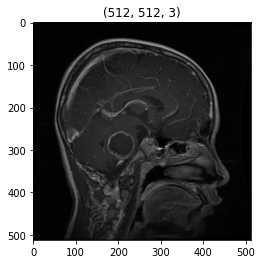

In [ ]:
path = '/content/brain-tumor-mri-dataset/glioma/Te-gl_0214.jpg'
img = cv2.imread(path)
plt.imshow(img.astype("uint8"))
plt.title(str(img.shape))


In [ ]:
def show_samples(num_samples, base_dir, data_augmentation=False):
  plt.figure(figsize=(10, 8))
  i = 0
  for label in CLASSES:
    path = base_dir + '/' + label
    for img_name in os.listdir(path):
      img = cv2.imread(path + "/" + img_name)
      if data_augmentation is not False:
        img = data_augmentation(img).numpy()
      ax = plt.subplot(4, num_samples, i + 1)
      plt.imshow(img.astype("uint8"))
      plt.title(label)
      plt.axis("off")
      i += 1
      if i % num_samples == 0:
        break

Some examples of the images of the dataset are shown below. As we can see the images of the MRI scans on the dataset have different sizes

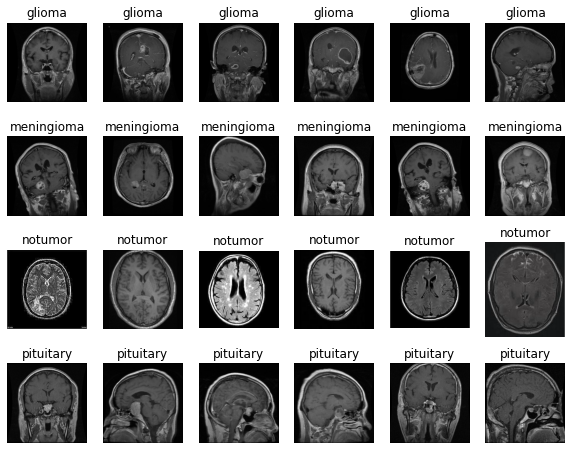

In [ ]:
show_samples(6, DATA_DIR)

# Data Preprocess

On the Kaggle page of the dataset the author of the dataset suggests to crop the images removing the black margins of the MRI scans, and they provided the code for the cropping:

In [ ]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img

Now we use this function to crop the images. In addition we resize the images creating a new folder with all the dataset images cropped and with uniform size. The new image size is set to 224 because it is the standard size of the input images of the pretrained Convolutional Neural Network that we will use later. 

In [ ]:
IMG_SIZE = 224
dir_list = os.listdir(DATA_DIR)
for dir in dir_list:
  save_path = os.path.join(PREPROCESSED_DIR, dir)
  path = os.path.join(DATA_DIR,dir)
  image_dir = os.listdir(path)
  print("Cleaning the images in " + dir)
  for img in tqdm(image_dir):
    image = cv2.imread(os.path.join(path,img))
    new_img = crop_img(image)
    new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
    if not os.path.exists(save_path):
      os.makedirs(save_path)
    cv2.imwrite(save_path+'/'+img, new_img)

Cleaning the images in pituitary


100%|██████████| 1757/1757 [00:09<00:00, 184.40it/s]


Cleaning the images in meningioma


100%|██████████| 1645/1645 [00:08<00:00, 197.69it/s]


Cleaning the images in glioma


100%|██████████| 1621/1621 [00:07<00:00, 219.03it/s]


Cleaning the images in notumor


100%|██████████| 2000/2000 [00:07<00:00, 267.58it/s]


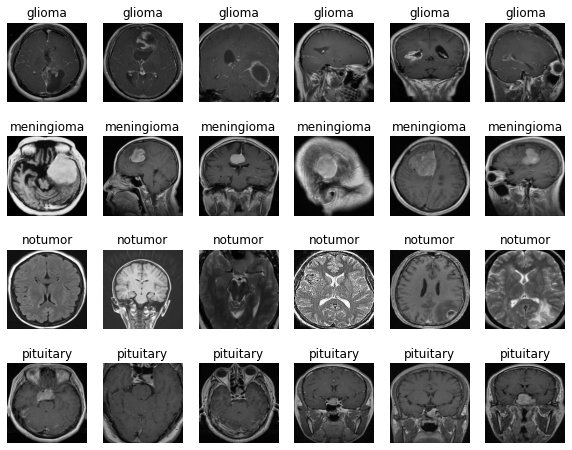

In [ ]:
show_samples(6, PREPROCESSED_DIR)

It's important to specify that later all the models provided will use data augmentation in order to fight overfitting, changing randomly the horizontal orientation of the images and the contrast. The layers that define this transformations are defined in the notebook utilities.ipynb.


Some examples of transformed images are shown below.

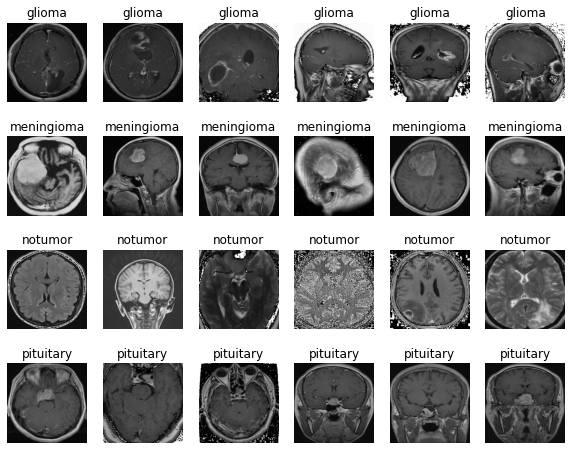

In [ ]:
show_samples(6, PREPROCESSED_DIR, data_augmentation_layers)

# Splitting the dataset
We decide to split the dataset with the percentage of 0.6 for the training set, 0.2 for the validation set and 0.2 for the test set.

In [ ]:
!pip install split-folders tqdm
import splitfolders

splitfolders.ratio(PREPROCESSED_DIR, output=SETS_DIR, seed=123, ratio=(0.6, 0.2, 0.2), group_prefix=None)

Copying files: 7023 files [00:01, 4242.34 files/s]


We upload a zip file containing the datasplits on the drive.

In [ ]:
%%capture
!zip -r "/content/gdrive/MyDrive/BrainTumorClassifier/brain-tumor-mri-splits.zip" "/content/brain-tumor-mri-splits"